## Programming Exercise 8: Anomaly Detection and Recommender Systems
#### Author - Rishabh Jain

In [1]:
import warnings,os
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

from scipy.io import loadmat

### 1&nbsp;&nbsp;&nbsp;&nbsp;Anomaly detection

#### Problem Statement
In this part of the exercise, we will implement an anomaly detection algorithm to detect the anomalous behavior in server computers. The featues measures the throughput (mb/s) and latency (ms) of response of each server. While our servers were operating, we collected m=307 examples of how they were behaving, and thus have an unlabeled dataset. We suspect that the vast majority of these examples are "Normal" (Non-anomalous) examples of servers operating normally, but there might also be some examples of servers acting anomalously within the dataset.

**We will use a gaussian model to detect the anomalies in our dataset. On this dataset, we will fit a gaussian distribution and then find the values that have very low probability and hence can be considered anomalies.**

In [2]:
# Loading dataset
mat=loadmat('ex8data1.mat')
X=mat['X']
print(*mat.keys(),sep='\n')

__header__
__version__
__globals__
X
Xval
yval


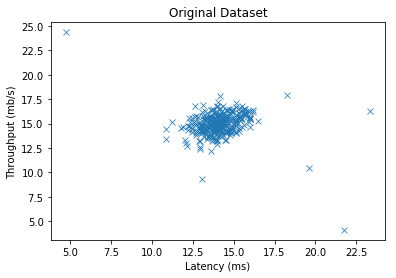

In [3]:
fig=sns.scatterplot(X[:,0],X[:,1],marker='x')
fig.set(xlabel='Latency (ms)',ylabel='Throughput (mb/s)',title='Original Dataset');

#### 1.1&nbsp;&nbsp;&nbsp;&nbsp;Gaussian Distribution
To perform anomaly detection, we will first need to fit a model to the data's distribution.  
Given a training set,we want to estimate the gaussian distribution for each of the features. For each feature, we need to find the parameters $\mu_{i}$ and $\sigma_{i}^{2}$ that fit the data. The gaussian distribution is given by:

$$\boxed{p(x_{j};\mu_{j},\sigma_{j}^{2})=\frac{1}{\sqrt{2\pi\sigma_{j}^{2}}}e^{-\frac{(X_{j}-\mu_{j})^{2}}{2\sigma_{j}^{2}}}}$$

$$p(x)=\Pi_{j=1}^{n}p(x_{j};\mu_{j},\sigma_{j}^{2})$$

$$\text{Anomaly, if }p(x)< \varepsilon$$

In [4]:
def mutlivariateGaussian(X,mu,sigma):
    p=(1/(np.sqrt(2*np.pi*np.power(sigma,2))))*np.exp(-np.power(X-mu,2)/(2*np.power(sigma,2)))
    p=np.product(p,axis=1).reshape((-1,1))
    return p

#### 1.2&nbsp;&nbsp;&nbsp;&nbsp;Estimating parameters for a Gaussian
We can estimate the parameters ($\mu_{i},\sigma_{i}^{2}$) of the i-th feature by using the following equations. To estimate the mean, we will use
$$\mu_{i}=\frac{1}{m}\sum_{j=1}^{m}x_{i}^{(j)}$$

And for the variance, we will use:
$$\sigma_{i}^{2}=\frac{1}{m}\sum_{j=1}^{m}(x_{i}^{(j)}-\mu_{i})^2$$

In [5]:
def estimateGaussian(X):
    mu=np.mean(X,axis=0)
    sigma=np.std(X,axis=0)
    return (mu,sigma)

Let's look at the Gaussian distribution contours of the distribution fit to the dataset.

In [6]:
def plotGaussianContour(X,mu,sigma,title=None):
    # Constructing grid around the min and max range of original data
    temp=np.linspace(np.min(X)-5,np.max(X)+5)
    [x1,x2]=np.meshgrid(temp,temp)
    # Computing the Gaussian Density Probability for the grid
    temp=np.array([x1.reshape(-1),x2.reshape(-1)]).T
    z=mutlivariateGaussian(temp,mu,sigma).reshape(x1.shape)
    # Plotting
    levels=np.power(10,list(map(lambda x:float(x),list(range(-20,0,3)))))
    plt.contour(x1,x2,z,levels=levels);
    fig=sns.scatterplot(X[:,0],X[:,1],marker='x')
    title='Gaussian Distribution Contours' if title==None else title
    fig.set(xlabel='Latency (ms)',ylabel='Throughput (mb/s)',title=title);

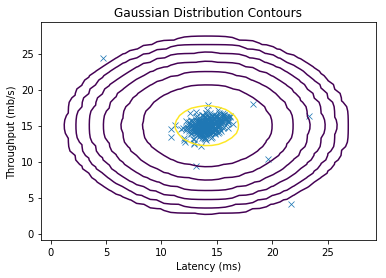

In [7]:
# Estimating Gaussian parameters
mu,sigma=estimateGaussian(X)
# Computing Density Probability
p=mutlivariateGaussian(X,mu,sigma)
# PLotting
plotGaussianContour(X,mu,sigma);

#### 1.3&nbsp;&nbsp;&nbsp;&nbsp;Selecting the threshold, $\varepsilon$
Now that we have estimated the gaussian parameters, we can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are the anomalies is to select the threshold based on a cross validation set. In this part of the exericse, we will implement an algorithm to select the threshold using F1 score on a cross validation set.  

**$y=1$ corresponds to an anomalous examples and $y=0$ corresponds to a normal examples.**

In [8]:
Xval=mat['Xval']
yval=mat['yval']

For many different values of $\varepsilon$, we will compute the resulting $F_1$ score by computing how many examples the current threshold classifies correctly and incorrectly. The $F_1$ score is computed using **Precision** (prec) and **Recall** (rec):

$$\boxed{F1=\frac{2.prec.rec}{prec+rec}}$$

We can compute Precision (prec) and Recall (rec) using:

$$\boxed{prec=\frac{tp}{tp+fp}}$$

$$\boxed{rec=\frac{tp}{tp+fn}}$$

where,
- $tp$ is the number of true positives: the ground truth label says it's an anomaly and our algorithm classified it as an anomaly.
- $fp$ is the number of false positives: the ground truth label says it's not an anomaly and our algorithm classified it as  an anomaly.
- $fn$ is the number of false negatives: the ground truth labels says it's an anomaly and our alogrithm classified it as not being anomalous.

In [9]:
def selectThreshold(yval,pval):
    '''
     Returns the threshold value of epsilon and the corresponding F1 score.
    '''
    bestEpsilon=bestF1=F1=0
    epsilons=np.linspace(np.min(pval),np.max(pval),1000)
    for epsilon in epsilons:
        cvPrediction=pval<epsilon
        tp=np.sum((cvPrediction==1) & (yval==1))
        fp=np.sum((cvPrediction==1) & (yval==0))
        fn=np.sum((cvPrediction==0) & (yval==1))
        prec=rec=0
        # Computing Precision
        if tp+fp>0:
            prec=tp/(tp+fp)
        # Computing Recall
        if tp+fn>0:
            rec=tp/(tp+fn)
        # Computing F1 Score
        if prec+rec>0:
            F1=(2*prec*rec)/(prec+rec)
        if F1>bestF1:
            bestF1=F1
            bestEpsilon=epsilon
    return (bestEpsilon,bestF1)

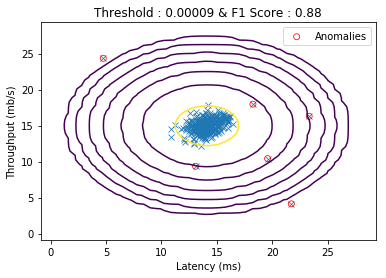

In [10]:
# Using sample mean and std. to compute density probability for cross validation set
pval=mutlivariateGaussian(Xval,mu,sigma)
# Calculating the threshold based on the best F1 Score
epsilon,f1=selectThreshold(yval,pval)
# Getting indices for anomalous examples
indices=np.where((p<epsilon)==True)[0]
# Plotting anomalies
title=f'Threshold : {epsilon:.5f} & F1 Score : {f1:.2f}'
plotGaussianContour(X,mu,sigma,title=title)
sns.scatterplot(X[indices,0],X[indices,1],marker='o',facecolors='none',edgecolor='r',label='Anomalies');

#### 1.4&nbsp;&nbsp;&nbsp;&nbsp;High Dimensional Dataset